<a href="https://colab.research.google.com/github/PulseProgrammer/EmoTone/blob/LSTM-Approach/EmoTone_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing Required packages 


In [ ]:
import pandas as pd
import librosa 
import os 
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import Input, Dense, LSTM, Dropout
import glob
import random
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score

Data Preprocessing Steps

In [ ]:
dataset_path = "/content/drive/MyDrive/Dataset/TESS Toronto emotional speech set data"  #path to dataset 

In [ ]:
audios = []
emotion = []
speaker= []       #setting up lists to store individuals (X and Ys) for data to fit into the model

In [ ]:
#Iterating over the dataset directory to store audio file paths and truth labels in the lists defined above 

for file_path in glob.glob(dataset_path + "/*/*"):      
    audios.append(file_path)
    parts = file_path.split("_")
    emotion.append(parts[-1].split(".")[0])
    speaker.append((parts[-3].split("/")[1]))

speaker[2374] ='OAF'  #Specific audio file is named wrong in the audio set directory 

In [ ]:
print(audios[2374]) #file which is not named properly in the dataset 
print(speaker[2374]) #checking the updated file name
print(len(emotion))
print(len(audios))
print(len(speaker))

/content/drive/MyDrive/Dataset/TESS Toronto emotional speech set data/OAF_neutral/OA_bite_neutral.wav
OAF
2799
2799
2799


In [ ]:
unique_elements = set(emotion) #creating a set of unique elements of emotion labels
print(unique_elements)
unique_elements = set(speaker) #creating a set of unique elements of speaker labels
print(unique_elements)

{'happy', 'disgust', 'angry', 'ps', 'sad', 'neutral', 'fear'}
{'OAF', 'YAF'}


In [ ]:
data = [[a, b, c] for a, b, c in zip(audios, emotion, speaker)]     #storing all of our data into a list to be converted into an array to be used with the model
DATA = np.array(data)     #type casting into an array 
DATA.shape
np.random.shuffle(DATA) #shuffle the data since everything is arranged in an well-ordered manner which leads to improper results 

In [ ]:
def m_extract_mfcc(filename):
    y, sr = librosa.load(filename)  #load audio file 
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0) #create a single vector - average or summary of the MFCC features across the entire audio file
    return mfcc

In [ ]:
x=[] #empty list to store mfcc of each audio file 
for i in range(len(DATA)): 
    audio_path = DATA[i][0]  #audio file paths are the first element in every element of our list containing audio files path and corresponding labels 
    mel_spec = m_extract_mfcc(audio_path) #data preprocessing
    x.append(mel_spec)
print(type(x))
print(len(x))

<class 'list'>
2799


In [ ]:
X = [i for i in x]
X = np.array(X) #type casting into an array 
print("Before expanding dimensions:",X.shape) 
X = np.expand_dims(X, -1) #expanding dimensions so that it will fit for the tensorflow model - (batch_size, timesteps, input_dim, channels)
print("After expanding dimensions:", X.shape)

Before expanding dimensions: (2799, 40)
After expanding dimensions: (2799, 40, 1)


Label Encoding

In [ ]:
emo = []
spe = []
le = LabelEncoder()                         #creating label encoder and fitting it on our labels for y_truths for training
for i in range(len(DATA)): 
    z = DATA[i][1]
    emo.append(z)
y_encoded = le.fit_transform(emo)
y_emotion = to_categorical(y_encoded)       #convert label-encoded categorical data into one-hot encoded vectors
for i in range(len(DATA)): 
    z = DATA[i][2]
    spe.append(z)
y_encoded_1 = le.fit_transform(spe)
y_speaker = to_categorical(y_encoded_1)     #convert label-encoded categorical data into one-hot encoded vectors

print(y_encoded[4])
print(emo[4])


2
fear


Creating a Model Architecture

In [ ]:
# Define input layer with shape (40, 1) - from code above
inputs = Input(shape=(40, 1))
lstm1 = LSTM(128, return_sequences=False)(inputs)
dropout1 = Dropout(0.2)(lstm1) #regularisation
dense1 = Dense(64, activation='relu')(dropout1)
dropout2 = Dropout(0.2)(dense1) #regularisation
emotion_output = Dense(7, activation='softmax', name='emotion_output')(dropout2)
dense2 = Dense(32, activation='relu')(dropout1)
dropout3 = Dropout(0.2)(dense2) #regularisation
speaker_output = Dense(2, activation='softmax', name='speaker_output')(dropout3)

model = Model(inputs=inputs, outputs=[emotion_output, speaker_output]) #create model instance

metrics = ['accuracy']
learning_rate = 0.001 
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
losses = ['categorical_crossentropy', keras.losses.BinaryCrossentropy()]


model.compile(optimizer=optimizer, loss=losses, metrics=metrics) #model complilation
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 40, 1)]      0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 128)          66560       ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 128)          0           ['lstm[0][0]']                   
                                                                                                  
 dense (Dense)                  (None, 64)           8256        ['dropout[0][0]']                
                                                                                              

Training and Validation on our dataset - Emotion and Speaker Recognition - Classification

In [ ]:
history = model.fit(X, [y_emotion, y_speaker], validation_split=0.3, epochs=20, batch_size=32)

Epoch 1/20
62/62 [==============================] - 11s 19ms/step - loss: 1.7869 - emotion_output_loss: 1.1913 - speaker_output_loss: 0.5956 - emotion_output_accuracy: 0.5294 - speaker_output_accuracy: 0.6784 - val_loss: 1.0135 - val_emotion_output_loss: 0.5520 - val_speaker_output_loss: 0.4615 - val_emotion_output_accuracy: 0.7940 - val_speaker_output_accuracy: 0.8167
Epoch 2/20
62/62 [==============================] - 1s 10ms/step - loss: 0.7606 - emotion_output_loss: 0.4296 - speaker_output_loss: 0.3311 - emotion_output_accuracy: 0.8448 - speaker_output_accuracy: 0.8882 - val_loss: 0.4321 - val_emotion_output_loss: 0.2639 - val_speaker_output_loss: 0.1682 - val_emotion_output_accuracy: 0.9048 - val_speaker_output_accuracy: 0.9476
Epoch 3/20
62/62 [==============================] - 1s 11ms/step - loss: 0.3967 - emotion_output_loss: 0.2476 - speaker_output_loss: 0.1492 - emotion_output_accuracy: 0.9209 - speaker_output_accuracy: 0.9576 - val_loss: 0.2852 - val_emotion_output_loss: 0.1

Plotting losses and model accuracies for Training and Validation steps

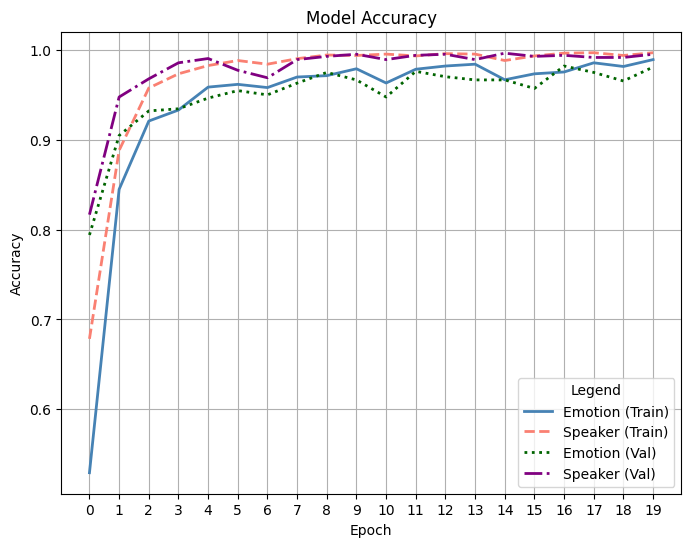

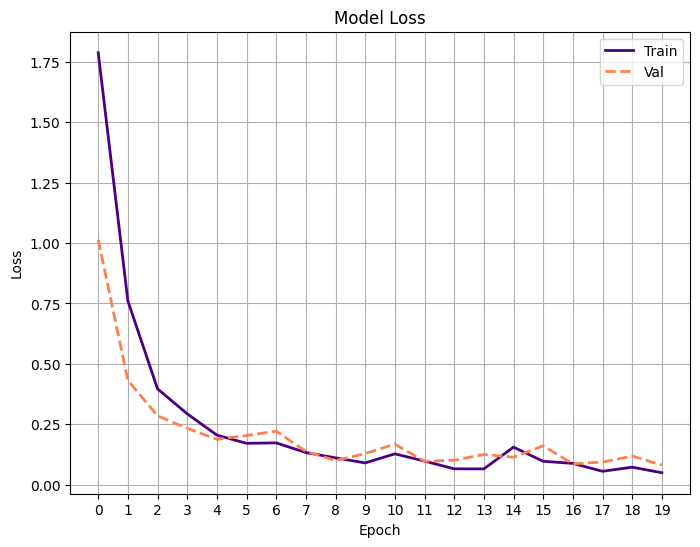

In [ ]:
# Plot accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.epoch, history.history['emotion_output_accuracy'], linestyle='-', color='steelblue', linewidth=2, label='Emotion (Train)')
plt.plot(history.epoch, history.history['speaker_output_accuracy'], linestyle='--', color='salmon', linewidth=2, label='Speaker (Train)')
plt.plot(history.epoch, history.history['val_emotion_output_accuracy'], linestyle=':', color='darkgreen', linewidth=2, label='Emotion (Val)')
plt.plot(history.epoch, history.history['val_speaker_output_accuracy'], linestyle='-.', color='purple', linewidth=2, label='Speaker (Val)')
plt.grid(True)
plt.legend(title='Legend', loc='lower right')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(history.epoch)
plt.show()

print("\n")
print("\n")

# Plot loss
plt.figure(figsize=(8, 6))
plt.plot(history.epoch, history.history['loss'], linestyle='-', color='indigo', linewidth=2, label='Train')
plt.plot(history.epoch, history.history['val_loss'], linestyle='--', color='coral', linewidth=2, label='Val')
plt.grid(True)
plt.legend(loc='upper right')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(history.epoch)
plt.show()


Saving - Loading Model 

Running the Model on the test audio (Not part of the traning)

In [ ]:
model.save("model.h5")    #save model for prediction
model = load_model("/content/model.h5") #load model


#test audio pre processing
emotion_gt = []
speaker_gt = []
test_file = "/content/YAF_rain_fear.wav"
parts = test_file.split("_")
emotion_gt.append(parts[-1].split(".")[0])
speaker_gt.append((parts[-3].split("/")[2]))
x_test= []
mel_spec = m_extract_mfcc(test_file)
x_test.append(mel_spec)
print(type(x_test))
print(len(x_test))
X_test = np.array(x_test)
print(type(X_test))
print(X_test.shape)
print(emotion_gt)
print(speaker_gt)

<class 'list'>
1
<class 'numpy.ndarray'>
(1, 40)
['fear']
['YAF']


In [ ]:
y_pred_emotion, y_pred_speaker = model.predict(X_test)    #prediction

1/1 [==============================] - 1s 666ms/step


Prediction

In [ ]:
emotion_labels = ['neutral', 'disgust', 'fear', 'ps', 'happy', 'angry', 'sad']
speaker_labels = ['YAF', 'OAF']

# Create and fit LabelEncoder for emotion labels
emotion_le = LabelEncoder()
emotion_le.fit(emotion_labels)

# Create and fit LabelEncoder for speaker labels
speaker_le = LabelEncoder()
speaker_le.fit(speaker_labels)

# Convert the predicted emotion and speaker labels from one-hot encoded format to class labels
emotion_labels = emotion_le.inverse_transform(np.argmax(y_pred_emotion, axis=1))
speaker_labels = speaker_le.inverse_transform(np.argmax(y_pred_speaker, axis=1))

# Print the converted labels
print(emotion_labels)
print(speaker_labels)


['fear']
['YAF']


Accuracy measure




In [ ]:
# Calculate accuracy for emotion labels
emotion_accuracy = accuracy_score(emotion_gt, emotion_labels)

# Calculate accuracy for speaker labels
speaker_accuracy = accuracy_score(speaker_gt, speaker_labels)

# Print the accuracies
print(f'Emotion Accuracy: {emotion_accuracy:.2f}')
print(f'Speaker Accuracy: {speaker_accuracy:.2f}')


Emotion Accuracy: 1.00
Speaker Accuracy: 1.00


Precision and Recall

In [ ]:

# Calculate true positives, false positives, false negatives for emotion labels
TP_emotion = np.sum((emotion_gt == emotion_labels) & (emotion_labels != 'neutral'))
FP_emotion = np.sum((emotion_gt != emotion_labels) & (emotion_labels != 'neutral'))
FN_emotion = np.sum((emotion_gt == 'neutral') & (emotion_labels != 'neutral'))

# Calculate precision and recall for emotion labels
precision_emotion = precision_score(emotion_gt, emotion_labels, average='weighted', labels=emotion_labels)
recall_emotion = recall_score(emotion_gt, emotion_labels, average='weighted', labels=emotion_labels)

# Calculate true positives, false positives, false negatives for speaker labels
TP_speaker = np.sum(speaker_gt == speaker_labels)
FP_speaker = np.sum((speaker_gt != speaker_labels) & (speaker_labels != 'neutral'))
FN_speaker = np.sum(speaker_gt != speaker_labels)

# Calculate precision and recall for speaker labels
precision_speaker = precision_score(speaker_gt, speaker_labels, average='weighted', labels=speaker_labels)
recall_speaker = recall_score(speaker_gt, speaker_labels, average='weighted', labels=speaker_labels)

print("Emotion Precision:", precision_emotion)
print("Emotion Recall:", recall_emotion)
print("Speaker Precision:", precision_speaker)
print("Speaker Recall:", recall_speaker)


Emotion Precision: 1.0
Emotion Recall: 1.0
Speaker Precision: 1.0
Speaker Recall: 1.0


Saving - Loading Model 

Running the Model on the test audio (Custom recorded sample)

In [ ]:
#test audio pre processing

test_file = "/content/yaf-like_hapy_happy.wav"

x_test_new= []

y, sr = librosa.load(test_file, sr = 24400)  #load audio file 
mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)
# mel_spec = m_extract_mfcc(test_file)
x_test_new.append(mfcc)

print(type(x_test_new))
print(len(x_test_new))
X_test_new = np.array(x_test_new)
print(type(X_test_new))
print(X_test_new.shape)




<class 'list'>
1
<class 'numpy.ndarray'>
(1, 40)


<ipython-input-137-366671fc8992>:7: UserWarning:

PySoundFile failed. Trying audioread instead.

/usr/local/lib/python3.9/dist-packages/librosa/core/audio.py:184: FutureWarning:

librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.



In [ ]:
y_pred_emotion, y_pred_speaker = model.predict(X_test_new)    #prediction

1/1 [==============================] - 0s 23ms/step


Prediction

In [ ]:
emotion_labels = ['neutral', 'disgust', 'fear', 'ps', 'happy', 'angry', 'sad']
speaker_labels = ['YAF', 'OAF']

# Create and fit LabelEncoder for emotion labels
emotion_le = LabelEncoder()
emotion_le.fit(emotion_labels)

# Create and fit LabelEncoder for speaker labels
speaker_le = LabelEncoder()
speaker_le.fit(speaker_labels)

# Convert the predicted emotion and speaker labels from one-hot encoded format to class labels
emotion_labels = emotion_le.inverse_transform(np.argmax(y_pred_emotion, axis=1))
speaker_labels = speaker_le.inverse_transform(np.argmax(y_pred_speaker, axis=1))

# Print the converted labels
print(emotion_labels)
print(speaker_labels)


['disgust']
['YAF']
